Федосеев Роман Константинович, группа 4111, ИМИСиЦЭ

25.11.2021

In [1]:
# pip install -U scikit-fuzzy

In [2]:
# импорты всего нужного

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import preprocessing
import seaborn as sn

import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.figure_factory as ff

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


# Использование cufflinks в офлайн-режиме
import cufflinks
cufflinks.go_offline()

# Настройка глобальной темы cufflinks
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

In [3]:
# аккуртарный вывод

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 10, 3

# игнор варнингов ибо некрасиво
import warnings
warnings.filterwarnings('ignore')

In [7]:
# загрузка датасета

dt = pd.read_excel("test_data.xlsx")

In [8]:
dt.head(10)

,Возраст,Пол,Состоит в браке,Иждивенцы,Доход,Опыт работы,Срок проживания,Недвижимость,Месячный платеж,Благонадежный заемщик
0,28,женский,Да,0,9000,9.0,7,0,3946,Нет
1,39,мужской,Да,1,13500,17.0,6,0,2460,Да
2,31,мужской,Нет,2,7000,11.0,3,0,3126,Нет
3,34,мужской,Нет,1,10200,15.0,2,41,3280,Да
4,46,женский,Да,2,8500,20.0,8,0,3348,Да
5,30,женский,Да,2,9500,12.0,30,35,4612,Нет
6,47,мужской,Нет,2,7900,14.5,6,67,2870,Нет
7,33,мужской,Нет,2,12600,15.0,23,0,2050,Да
8,22,мужской,Нет,0,34000,4.0,19,33,2562,Да
9,30,мужской,Да,1,33000,10.0,8,0,1948,Да


In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Возраст                999 non-null    int64  
 1   Пол                    999 non-null    object 
 2   Состоит в браке        999 non-null    object 
 3   Иждивенцы              999 non-null    int64  
 4   Доход                  999 non-null    int64  
 5   Опыт работы            999 non-null    float64
 6   Срок проживания        999 non-null    int64  
 7   Недвижимость           999 non-null    int64  
 8   Месячный платеж        999 non-null    int64  
 9   Благонадежный заемщик  999 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.2+ KB


#### Распределение признаков

In [10]:
# здесь кодируются категориальные фичи чтоб удоднее было смотреть 
# и таргет посмотреть тоже

dt_enc = dt.copy()

dt_enc.loc[dt_enc['Пол'] == 'мужской', 'Пол'] = 1
dt_enc.loc[dt_enc['Пол'] == 'женский', 'Пол'] = 0

dt_enc.loc[dt_enc['Состоит в браке'] == 'Да', 'Состоит в браке'] = 1
dt_enc.loc[dt_enc['Состоит в браке'] == 'Нет', 'Состоит в браке'] = 0

dt_enc.loc[dt_enc['Благонадежный заемщик'] == 'Да', 'Благонадежный заемщик'] = 1
dt_enc.loc[dt_enc['Благонадежный заемщик'] == 'Нет', 'Благонадежный заемщик'] = 0

# to num
dt_enc['Пол'] = pd.to_numeric(dt_enc['Пол'])
dt_enc['Состоит в браке'] = pd.to_numeric(dt_enc['Состоит в браке'])
dt_enc['Благонадежный заемщик'] = pd.to_numeric(dt_enc['Благонадежный заемщик'])

In [11]:
dt_enc.columns = [c.replace(' ', '_') for c in dt_enc.columns]

In [12]:
dt_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Возраст                999 non-null    int64  
 1   Пол                    999 non-null    int64  
 2   Состоит_в_браке        999 non-null    int64  
 3   Иждивенцы              999 non-null    int64  
 4   Доход                  999 non-null    int64  
 5   Опыт_работы            999 non-null    float64
 6   Срок_проживания        999 non-null    int64  
 7   Недвижимость           999 non-null    int64  
 8   Месячный_платеж        999 non-null    int64  
 9   Благонадежный_заемщик  999 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 78.2 KB


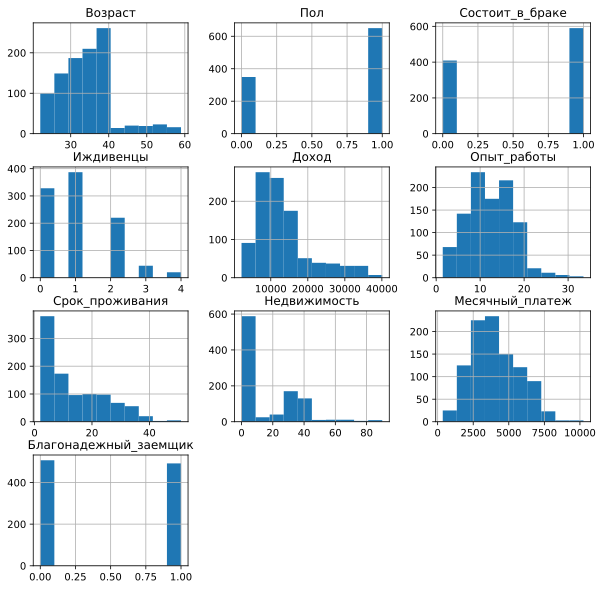

In [13]:
dt_enc.hist(figsize=(10, 10))
plt.show()

In [14]:
# ф-ия подсчета какая часть от месячного дохода - платеж по кредиту
def part_of_revenue(revenue, monthly_payment):

    return ( monthly_payment / revenue)

In [15]:
# новая фича

dt_enc['per_monthly_payment'] = dt_enc.apply(
    (lambda x: part_of_revenue(x['Доход'], x['Месячный_платеж'])*100), axis=1)

dt_enc.head()

,Возраст,Пол,Состоит_в_браке,Иждивенцы,Доход,Опыт_работы,Срок_проживания,Недвижимость,Месячный_платеж,Благонадежный_заемщик,per_monthly_payment
0,28,0,1,0,9000,9.0,7,0,3946,0,43.844444
1,39,1,1,1,13500,17.0,6,0,2460,1,18.222222
2,31,1,0,2,7000,11.0,3,0,3126,0,44.657143
3,34,1,0,1,10200,15.0,2,41,3280,1,32.156863
4,46,0,1,2,8500,20.0,8,0,3348,1,39.388235


In [16]:
# корреляция признаков

figure = ff.create_annotated_heatmap(
    z=dt_enc.corr().values,
    x=list(dt_enc.corr().columns),
    y=list(dt_enc.corr().index),
    annotation_text=dt_enc.corr().round(2).values,
    showscale=True)

figure.show()

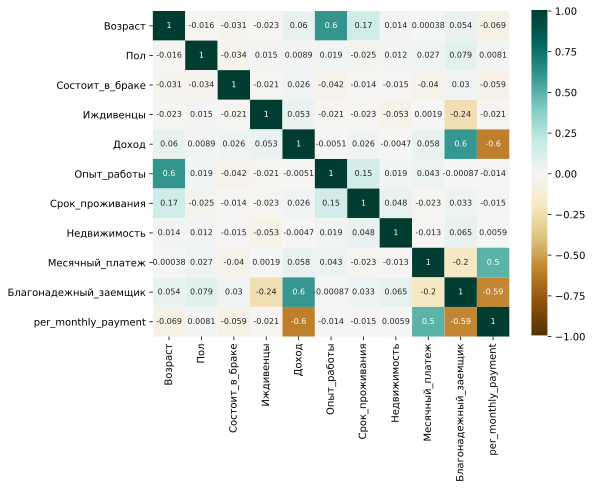

In [51]:
plt.figure(figsize=(8, 6))
sn.heatmap(dt_enc.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', annot_kws={"size": 8})
plt.show()

Видим, что с таргетом коррелирует только уровень дохода, платеж по кредиту (и процент его от дохода соответственно тоже) и кол-во иждевенцев
Поэтому в основном будем смотреть на эти признаки

###  Система нечеткого логического вывода

Будем использовать библиотеку skfuzzy
Библиотека с открытым исходным кодом, использует вывод по алгоритму Мамдани, руководствуясь нечеткой базой знаний вида
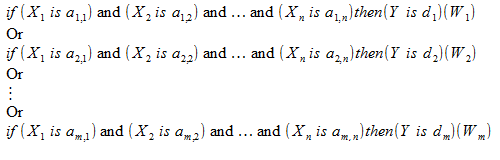
или

где
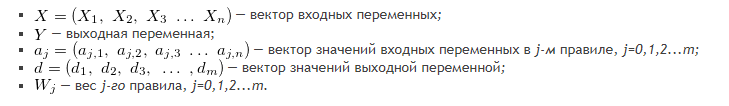


#### Определяем терм-множества

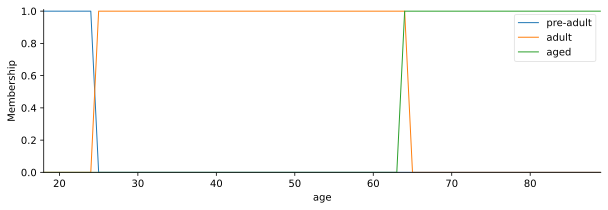

In [17]:
# Возраст
age = ctrl.Antecedent(np.arange(18,90,1), 'age')

pre_adult = fuzz.trapmf(age.universe, [18, 18, 24,25])

adult = fuzz.trapmf(age.universe, [25, 25, 64,64])

aged = fuzz.trapmf(age.universe, [64, 64, 90,90])

age['pre-adult'] = pre_adult
age['adult'] = adult
age['aged'] = aged

age.view()

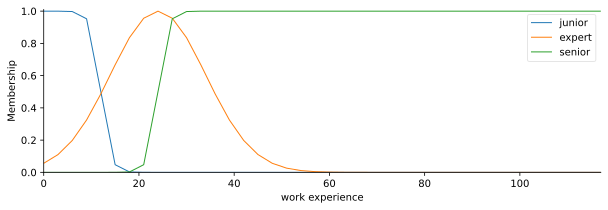

In [18]:
# Опыт работы

work_experience = ctrl.Antecedent(np.arange(0,120,3), 'work experience')

junior = fuzz.sigmf(work_experience.universe, 12,-1)
expert = fuzz.gaussmf(work_experience.universe, 24,10)
senior = fuzz.sigmf(work_experience.universe,24, 1)

work_experience['junior'] = junior 
work_experience['expert'] = expert
work_experience['senior'] = senior

work_experience.view()

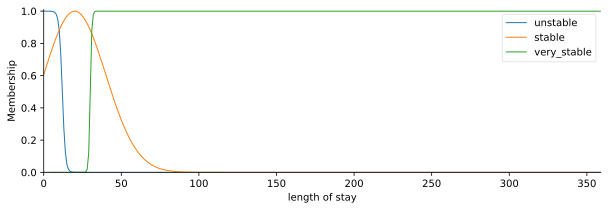

In [19]:
# срок проживания

length_of_stay = ctrl.Antecedent(np.arange(0,360,1), 'length of stay')

unstable = fuzz.sigmf(length_of_stay.universe, 12,-1)
stable = fuzz.gaussmf(length_of_stay.universe, 20,20)
very_stable = fuzz.sigmf(length_of_stay.universe,30, 2)

length_of_stay['unstable'] = unstable
length_of_stay['stable'] = stable 
length_of_stay['very_stable'] = very_stable

length_of_stay.view()

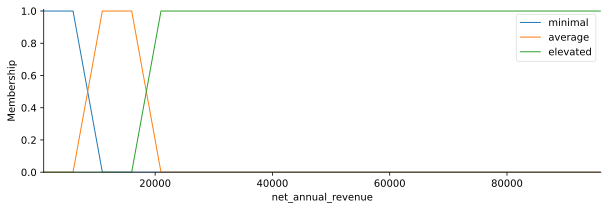

In [20]:
# доход

annual_revenue = ctrl.Antecedent(np.arange(1000,100000,5000), 'net_annual_revenue')

minimal = fuzz.sigmf(annual_revenue.universe, 10000, -1 )
average = fuzz.trapmf(annual_revenue.universe, [10000, 10000, 20000,20000])
elevated = fuzz.sigmf(annual_revenue.universe,20000,1)

annual_revenue['minimal'] = minimal 
annual_revenue['average'] = average
annual_revenue['elevated'] = elevated

annual_revenue.view()

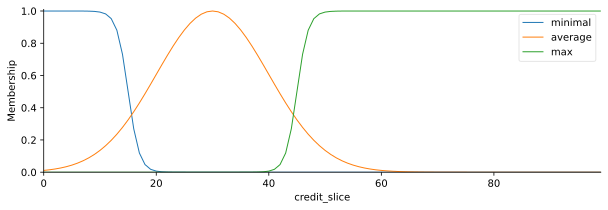

In [21]:
# какая часть от дохода - платеж по кредиту (%)

credit_slice = ctrl.Antecedent(np.arange(0,100,1), 'credit_slice')

minimal = fuzz.sigmf(credit_slice.universe, 15, -1)
average = fuzz.gaussmf(credit_slice.universe, 30, 10)
max = fuzz.sigmf(credit_slice.universe, 45,1)

credit_slice['minimal'] = minimal 
credit_slice['average'] = average
credit_slice['max'] = max

credit_slice.view()

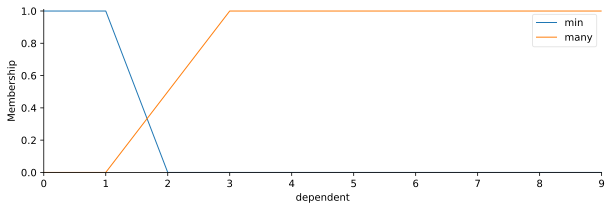

In [22]:
# Иждевенцы (мало (0-1 напрмер) или много)

dependent = ctrl.Antecedent(np.arange(0,10,1), 'dependent')

min = fuzz.trapmf(dependent.universe, [0, 0, 1, 1])
many = fuzz.sigmf(dependent.universe, 2, 10)

dependent['min'] = min 
dependent['many'] = many

dependent.view()

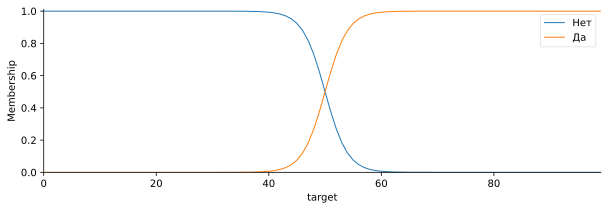

In [23]:
client_status = ctrl.Consequent(np.arange(0,100,1), 'target')

bad = fuzz.sigmf(client_status.universe, 50, -.5)
good = fuzz.sigmf(client_status.universe, 50,.5)

client_status['Нет'] = bad
client_status['Да'] = good

client_status.view()

#### Правила

In [24]:
rule1 = ctrl.Rule( (credit_slice['minimal'] | credit_slice['average']), client_status['Да'])


rule2 = ctrl.Rule( ((annual_revenue['average'] | annual_revenue['elevated']) &
                    credit_slice['minimal'] ), client_status['Да'])

rule3 = ctrl.Rule( (credit_slice['max'] ), client_status['Нет'])

rule4 = ctrl.Rule( (annual_revenue['minimal'] & dependent['many']), client_status['Нет'])

К примеру, второе выглядит так:

In [25]:
rule2

IF (net_annual_revenue[average] OR net_annual_revenue[elevated]) AND credit_slice[minimal] THEN target[Да]
	AND aggregation function : fmin
	OR aggregation function  : fmax

(<Figure size 720x216 with 1 Axes>, <AxesSubplot:>)

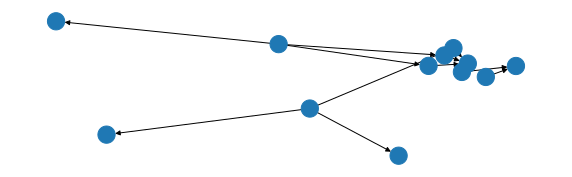

In [26]:
rule2.view()

#### Сама система

In [27]:
credit_scoring_rules = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
env_simulation = ctrl.ControlSystemSimulation(credit_scoring_rules)

#### Подсчет получившейся точности работы системы

In [30]:

dt_new = dt.copy()
dt_new['per_monthly_payment'] = dt_new.apply(
    (lambda x: part_of_revenue(x['Доход'], x['Месячный платеж'])*100), axis=1)
dt_new.head()

,Возраст,Пол,Состоит в браке,Иждивенцы,Доход,Опыт работы,Срок проживания,Недвижимость,Месячный платеж,Благонадежный заемщик,per_monthly_payment
0,28,женский,Да,0,9000,9.0,7,0,3946,Нет,43.844444
1,39,мужской,Да,1,13500,17.0,6,0,2460,Да,18.222222
2,31,мужской,Нет,2,7000,11.0,3,0,3126,Нет,44.657143
3,34,мужской,Нет,1,10200,15.0,2,41,3280,Да,32.156863
4,46,женский,Да,2,8500,20.0,8,0,3348,Да,39.388235


In [31]:
a = np.array([]) # вероятность классов

for index, row in dt_new.iterrows():
    env_simulation.input['credit_slice'] = row['per_monthly_payment']
    env_simulation.input['net_annual_revenue'] = row['Доход']
    env_simulation.input['dependent'] = row['Иждивенцы']
    env_simulation.compute()
    a = np.append(a, env_simulation.output['target'] / 100) # потому что вероятность
auc = roc_auc_score(dt_enc['Благонадежный_заемщик'], a)
print('ROC AUC = ', auc)
print('LogLoss = ', log_loss(dt_enc['Благонадежный_заемщик'], a))
print('Accuracy = ', accuracy_score(dt_enc['Благонадежный_заемщик'], np.around(a, decimals=0).astype(int)))

ROC AUC =  0.8498059684738859
LogLoss =  0.5227966238730638
Accuracy =  0.7707707707707707


### Для проверки можно построить маленькое грубое дерево 
(для леса мало данных, и дерево то легко переучится, но можно глубину ограничить и размер листьев)

Учитывая данные, эта модель должна неплохо отработать

<AxesSubplot:xlabel='per_monthly_payment', ylabel='Благонадежный_заемщик'>

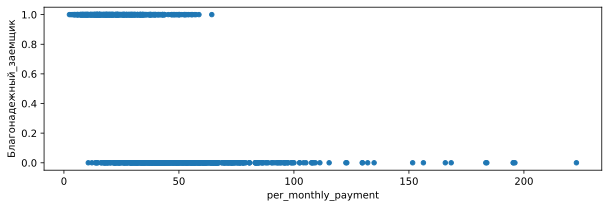

In [32]:
dt_enc.plot.scatter(y='Благонадежный_заемщик', x='per_monthly_payment')

In [33]:
px.histogram(x=dt_enc[dt_enc['Благонадежный_заемщик'] == 0]['per_monthly_payment'])


In [34]:
px.histogram(x=dt_enc[dt_enc['Благонадежный_заемщик'] == 1]['per_monthly_payment'])

In [35]:
X = dt_enc.loc[:, dt_enc.columns != 'Благонадежный_заемщик']
y = dt_enc['Благонадежный_заемщик']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.7,
                                                    random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)

In [37]:
pre = clf.predict(X_train)
pre.shape

(799,)

In [38]:
train_auc = roc_auc_score(y_train, pre)

print('train ROC AUC = ', train_auc)
print('train Accuracy = ', accuracy_score(y_train, pre))

train ROC AUC =  0.807280701754386
train Accuracy =  0.8072590738423029


In [39]:
print('test ROC AUC = ', roc_auc_score(y_test, clf.predict(X_test)))
print('test Accuracy = ', accuracy_score(y_test, clf.predict(X_test)))

test ROC AUC =  0.8459953773490101
test Accuracy =  0.845


In [40]:
for i, col in zip(X.columns, range(0, 10)):
    print(i, col)

Возраст 0
Пол 1
Состоит_в_браке 2
Иждивенцы 3
Доход 4
Опыт_работы 5
Срок_проживания 6
Недвижимость 7
Месячный_платеж 8
per_monthly_payment 9


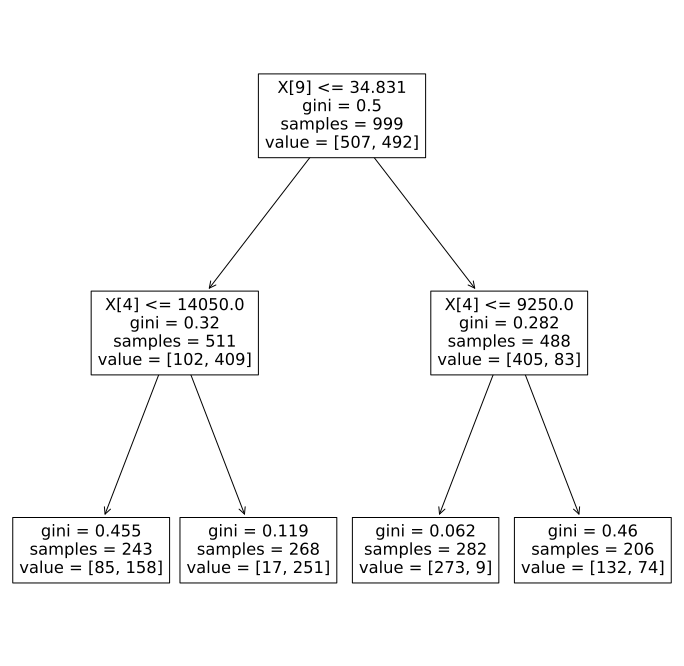

In [41]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf)
plt.show()

In [52]:
import lightgbm as lgb

In [70]:
LGBM_clf = lgb.LGBMClassifier(n_estimators=1000, max_depth=2, min_samples_leaf=50,
                                           random_state=42)
LGBM_clf.fit(X, y)
pre_2 = LGBM_clf.predict(X_train)
print('train ROC AUC = ', roc_auc_score(y_train, pre_2))
print('train Accuracy = ', accuracy_score(y_train, pre_2))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=50. Current value: min_data_in_leaf=50
train ROC AUC =  0.9857611010978208
train Accuracy =  0.9856938483547926


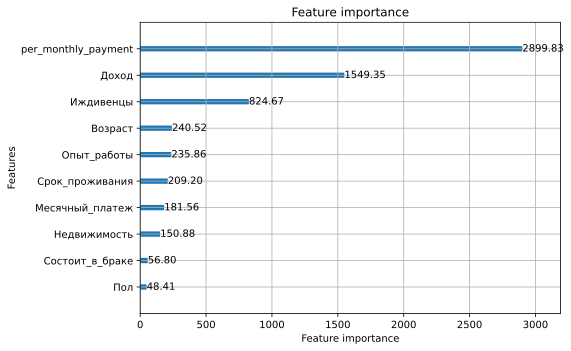

In [71]:
plt.rcParams["figure.figsize"] = (8, 5)
lgb.plot_importance(LGBM_clf, importance_type='gain', max_num_features=10, precision=2)
plt.tight_layout()
plt.show()

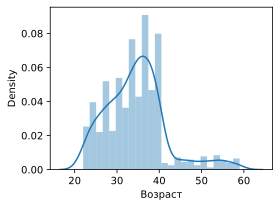

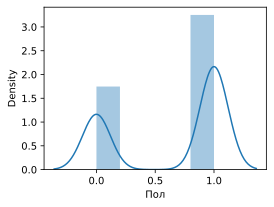

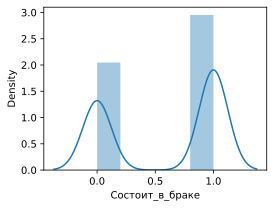

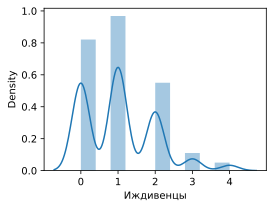

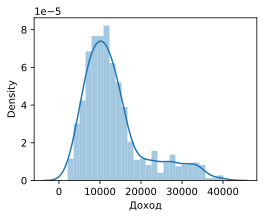

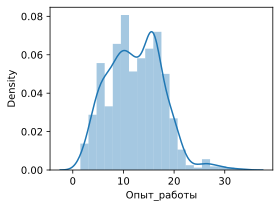

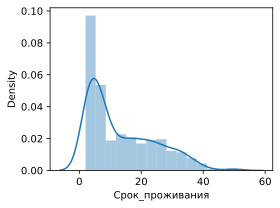

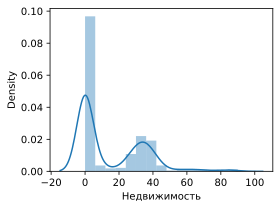

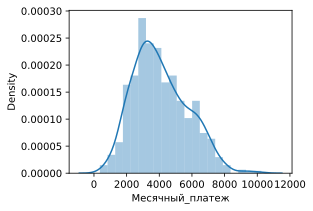

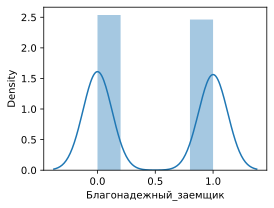

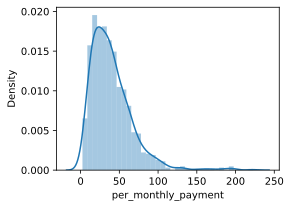

In [76]:
for column in dt_enc.columns:
    plt.rcParams["figure.figsize"] = (4, 3)
    plt.figure()
    sn.distplot(dt_enc[column])